In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u 
import astropy.constants as c
import time
import sys
from mpl_toolkits import mplot3d

In [13]:
class Body():
    
    def __init__(self, mass, x_vec, v_vec, name = None, has_units = True):
        self.name = name
        self.has_units = has_units
        if self.has_units:
            self.mass = mass.cgs
            self.x_vec = x_vec.cgs.value
            self.v_vec = v_vec.cgs.value
        else:
            self.mass = mass
            self.x_vec = x_vec
            self.v_vec = v_vec
            
    def return_vec(self):
        return np.concatenate((self.x_vec,self.v_vec))

    def return_mass(self):
        if self.has_units:
            return self.mass.cgs.value
        else:
            return self.mass
        
    def return_name(self):
        return self.name
    
class Simulation():
    
    def __init__(self, bodies, has_units = True):
        self.has_units = has_units
        self.bodies = bodies
        self.N_bodies = len(self.bodies)
        self.nDim = 6.0 
        self.quant_vec = np.concatenate(np.array([i.return_vec() for i in self.bodies]))
        self.mass_vec = np.array([i.return_mass() for i in self.bodies])
        self.name_vec = [i.return_name() for i in self.bodies]
        
    def set_diff_eq(self, calc_diff_eqs, **kwargs):
        self.diff_eq_kwargs = kwargs
        self.calc_diff_eqs = calc_diff_eqs
        
    def rk4(self, t, dt):
        k1 = dt * self.calc_diff_eqs(t, self.quant_vec, self.mass_vec, **self.diff_eq_kwargs) 
        k2 = dt * self.calc_diff_eqs(t + 0.5*dt, self.quant_vec + 0.5*k1, self.mass_vec, **self.diff_eq_kwargs)
        k3 = dt * self.calc_diff_eqs(t + 0.5*dt, self.quant_vec + 0.5*k2, self.mass_vec, **self.diff_eq_kwargs)
        k4 = dt * self.calc_diff_eqs(t + dt, self.quant_vec + k3, self.mass_vec, **self.diff_eq_kwargs)
        
        y_new = self.quant_vec + ((k1 + 2*k2 + 2*k3 + k4) / 6.0)
        return y_new
    
    def run(self, T, dt, t0=0):
        if not hasattr(self, 'calc_diff_eqs'):
            raise AttributeError('You must set a diff eq solver first.')
            
        if self.has_units:
            try:
                _ = t0.unit
            except:
                t0=(t0*T.unit).cgs.value
                
            T = T.cgs.value
            dt = dt.cgs.value
            
        self.history = [self.quant_vec]
        clock_time = t0
        nsteps = int((T - t0)/dt)
        start_time = time.time()
        for step in range(nsteps):
            sys.stdout.flush()
            sys.stdout.write('Integrating: step = {} / {} | simulation time = {}'.format(step,nsteps,round(clock_time,3)) + '\r')
            y_new = self.rk4(0,dt)
            self.history.append(y_new)
            self.quant_vec = y_new
            clock_time += dt
        runtime = time.time() - start_time
        print('\n')
        print('Simulation completed in {} seconds'.format(runtime))
        self.history = np.array(self.history)

def nbody_solve(t,y,masses):
    N_bodies = int(len(y) / 6)
    solved_vector = np.zeros(y.size)
    for i in range(N_bodies):
        ioffset = i * 6 
        for j in range(N_bodies):
            joffset = j*6
            solved_vector[ioffset] = y[ioffset+3]
            solved_vector[ioffset+1] = y[ioffset+4]
            solved_vector[ioffset+2] = y[ioffset+5]
            if i != j:
                dx = y[ioffset] - y[joffset]
                dy = y[ioffset+1] - y[joffset+1]
                dz = y[ioffset+2] - y[joffset+2] 
                r = (dx**2+dy**2+dz**2)**0.5
                ax = (-c.G.cgs * masses[j] / r**3) * dx
                ay = (-c.G.cgs * masses[j] / r**3) * dy
                az = (-c.G.cgs * masses[j] / r**3) * dz
                ax = ax.value
                ay = ay.value
                az = az.value
                solved_vector[ioffset+3] += ax
                solved_vector[ioffset+4] += ay
                solved_vector[ioffset+5] += az            
    return solved_vector

In [15]:
M_moon = 7.347e25
M_earth = (c.M_earth.cgs).value
M_sun = ((1*u.Msun).cgs).value

V_earth = ((2*3.14159*(1*u.AU)).cgs/ ((1*u.yr).cgs)).value
V_moon = ((1.022*u.km/u.s).cgs).value
V_sun = -(M_earth*V_earth + M_moon*V_moon)/M_sun

D_earth = ((1*u.AU).cgs).value
D_moon = ((384400*u.km).cgs).value + D_earth
#Basic Bodies in the Solar System
Sun = Body (mass = M_sun*u.g,
            x_vec = np.array ([0,0,0])*u.cm,
            v_vec = np.array ([0,V_sun,0])*u.cm/u.s,
            name = 'Sun')

Earth = Body (mass = M_earth*u.g,
            x_vec = np.array ([D_earth,0,0])*u.cm,
            v_vec = np.array ([0,V_earth,0])*u.cm/u.s,
            name = 'Earth')

Moon = Body (mass = M_moon*u.g,
            x_vec = np.array ([D_moon,0,0])*u.cm,
            v_vec = np.array ([0,V_earth,V_moon])*u.cm/u.s,
            name = 'Moon')

#Mercury
M_mercury = 3.285e26
D_mercury = 58.107e6
V_mercury = (2*3.14159*D_mercury/88*u.km/u.day).cgs.value

Mercury = Body (mass = M_mercury*u.g,
            x_vec = np.array ([D_mercury,0,0])*u.km,
            v_vec = np.array ([0,V_mercury,0])*u.cm/u.s,
            name = 'Mercury')

#Venus
M_venus = 4.867e27
D_venus = 108.91e6
V_venus = (2*3.14159*D_venus/225*u.km/u.day).cgs.value

Venus = Body (mass = M_venus*u.g,
            x_vec = np.array ([D_venus,0,0])*u.km,
            v_vec = np.array ([0,V_venus,0])*u.cm/u.s,
            name = 'Venus')


bodies = [Sun, Earth, Moon, Mercury, Venus]

simulation = Simulation(bodies)
simulation.set_diff_eq(nbody_solve)

simulation.run(500*u.day,1*u.day)

Integrating: step = 499 / 500 | simulation time = 43113600.0

Simulation completed in 14.218249082565308 seconds


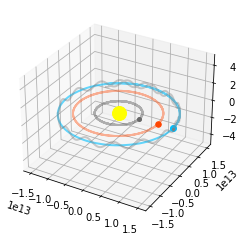

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

sunx = simulation.history[:,0]
suny = simulation.history[:,1]
sunz = simulation.history[:,2]

earthx = simulation.history[:,6]
earthy = simulation.history[:,7]
earthz = simulation.history[:,8]

moonx = simulation.history[:,12]
moony = simulation.history[:,13]
moonz = simulation.history[:,14]

mercuryx = simulation.history[:,18]
mercuryy = simulation.history[:,19]
mercuryz = simulation.history[:,20]

venusx = simulation.history[:,24]
venusy = simulation.history[:,25]
venusz = simulation.history[:,26]

startPosition = simulation.history[0]

plt.plot(sunx, suny, sunz, color = 'yellow', lw = 2, alpha = 0.4)
plt.plot(startPosition[0], startPosition[1], startPosition[2], marker = 'o', markerfacecolor = 'yellow', markeredgecolor = 'yellow', markersize = 14)

plt.plot(earthx, earthy, earthz, color = 'deepskyblue', lw = 2, alpha = 0.6)
plt.plot(startPosition[6], startPosition[7], startPosition[8], marker = 'o', markerfacecolor = 'deepskyblue', markeredgecolor = 'deepskyblue', markersize= 6)

plt.plot(moonx, moony, moonz, color = 'gray', lw = 2, alpha = 0.4)
plt.plot(startPosition[12], startPosition[13], startPosition[14], marker = 'o', markerfacecolor = 'gray', markeredgecolor = 'gray', markersize = 2)

plt.plot(mercuryx, mercuryy, mercuryz, color = 'dimgray', lw = 2, alpha = 0.5)
plt.plot(startPosition[18], startPosition[19], startPosition[20], marker = 'o', markerfacecolor = 'dimgray', markeredgecolor = 'dimgray', markersize = 4)

plt.plot(venusx, venusy, venusz, color = 'orangered', lw = 2, alpha = 0.4)
plt.plot(startPosition[24], startPosition[25], startPosition[26], marker = 'o', markerfacecolor = 'orangered', markeredgecolor = 'orangered', markersize = 5.5)


plt.plot(0,0,5e11, marker = '.', markerfacecolor = 'lightgray', markeredgecolor = 'lightgray', alpha = 0)
plt.plot(0,0,-5e11, marker = '.', markerfacecolor = 'lightgray', markeredgecolor = 'lightgray', alpha = 0)